# Testing Aer Simulator Methods

This notebook tests different Aer simulator methods with the Qonscious framework.

Available Aer simulation methods:
- **automatic**: Automatically select the best method
- **statevector**: State vector simulation
- **density_matrix**: Density matrix simulation
- **stabilizer**: Stabilizer simulation (Clifford circuits only)
- **matrix_product_state**: Matrix product state simulation
- **extended_stabilizer**: Extended stabilizer simulation
- **unitary**: Unitary matrix simulation
- **superop**: Superoperator simulation

## Setup and Imports

In [1]:
import json
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qonscious.adapters import AerSimulatorAdapter
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import AggregateQPUFigureOfMerit
from qonscious.actions import QonsciousCallable
from qonscious import run_conditionally
import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def create_test_circuit(n_qubits=3):
    """Create a simple Bell-like test circuit."""
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(n_qubits - 1):
        qc.cx(i, i + 1)
    qc.measure_all()
    return qc

def on_pass(backend_adapter, figureOfMeritResults):
    """Executed if merit check passes - runs a circuit and returns result."""
    firstFoMResult = figureOfMeritResults[0]
    print("\n--- Checks PASSED ---")
    properties = firstFoMResult.get('properties', {})
    print("\n--- Calculated Properties ---")
    pretty_properties = json.dumps(properties, indent=2)
    print(pretty_properties)
    num_qubits = properties.get('n_qubits', 'N/A')
    print(f"\nNumber of Qubits: {num_qubits}")
    print("-" * 25)
    
    # Execute a test circuit
    print("\n--- Running Test Circuit in on_pass ---")
    circuit = create_test_circuit(3)
    run_result = backend_adapter.run(circuit, shots=1000)
    print(f"Circuit executed successfully")
    print(f"Result counts: {run_result['counts']}")
    
    return run_result  # Return the experiment result

def on_fail(backend_adapter, figureOfMeritResults):
    """Executed if merit check fails."""
    firstFoMResult = figureOfMeritResults[0]
    print("\n--- Checks FAILED ---")
    properties = firstFoMResult.get('properties', {})
    print("\n--- Calculated Properties ---")
    pretty_properties = json.dumps(properties, indent=2)
    print(pretty_properties)
    return None

In [3]:
def plot_results(qonscious_result, method_name=""):
    counts = qonscious_result.get('experiment_result', {}).get('counts', {})
    if not counts:
        print("No experiment result to plot")
        return

    n = max(len(k) for k in counts)
    labels = [format(i, f'0{n}b') for i in range(2**n)]
    values = [counts.get(k, 0) for k in labels]
    N = sum(values)

    z0, o1 = '0'*n, '1'*n
    F = (counts.get(z0, 0) + counts.get(o1, 0)) / N if N else float('nan')

    fig, ax = plt.subplots()
    bars = ax.bar(labels, values)
    ax.set_title(f"{n}-qubit outcomes {method_name} (F={F:.3f})")
    ax.set_xlabel("Outcome")
    ax.set_ylabel("Counts")
    ax.set_ylim(bottom=0)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
    for bar, v in zip(bars, values):
        if v:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(v),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.show()



## Test Function for Each Method

In [4]:
def test_aer_method(method_name, n_qubits=3, qubit_threshold=2):
    """
    Test a specific Aer simulator method.
    
    Args:
        method_name: Aer simulation method
        n_qubits: Number of qubits for the simulator
        qubit_threshold: Minimum qubits required to pass check
    """
    print(f"\n{'='*60}")
    print(f"Testing Aer Simulator Method: {method_name}")
    print(f"{'='*60}")
    
    try:
        # Create simulator with specific method
        simulator = AerSimulator(method=method_name)
        sampler = Sampler()
        
        # Create mock qubit properties (for local simulator)
        qubits_properties = [
            {"T1": [100e-6], "T2": [80e-6]} for _ in range(n_qubits)
        ]
        
        # Create adapter
        adapter = AerSimulatorAdapter(sampler, simulator, qubits_properties)
        
        print(f"\nSimulator Method: {method_name}")
        print(f"Available Qubits: {adapter.n_qubits}")
        
        # Create merit compliance check
        check_QPU = MeritComplianceCheck(
            figure_of_merit=AggregateQPUFigureOfMerit(),
            decision_function=lambda r: r is not None and r["properties"]["n_qubits"] > qubit_threshold
        )
        
        # Run conditional check
        qonscious_result = run_conditionally(
            backend_adapter=adapter,
            checks=[check_QPU],
            on_pass=QonsciousCallable(on_pass),
            on_fail=QonsciousCallable(on_fail)
        )
        
        
        return qonscious_result
        
    except Exception as e:
        print(f"\nError testing method '{method_name}': {str(e)}")
        return None

## Test All Methods at Once


TESTING ALL AER SIMULATOR METHODS

Testing Aer Simulator Method: automatic

Simulator Method: automatic
Available Qubits: 29

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 29,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 29
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'111': 488, '000': 512}


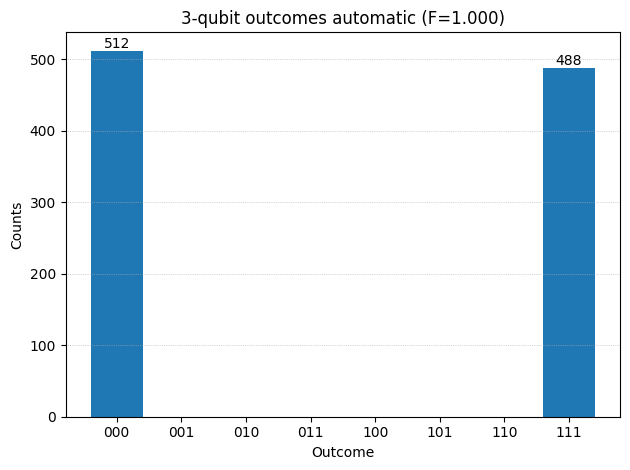




Testing Aer Simulator Method: statevector

Simulator Method: statevector
Available Qubits: 29

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 29,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 29
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'111': 480, '000': 520}


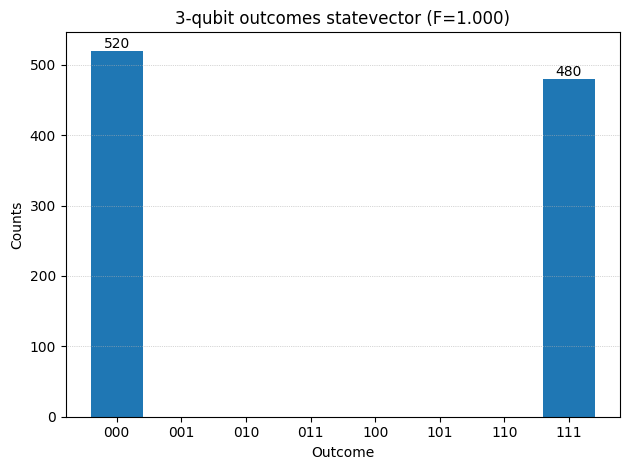




Testing Aer Simulator Method: density_matrix

Simulator Method: density_matrix
Available Qubits: 14

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 14,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 14
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'000': 516, '111': 484}


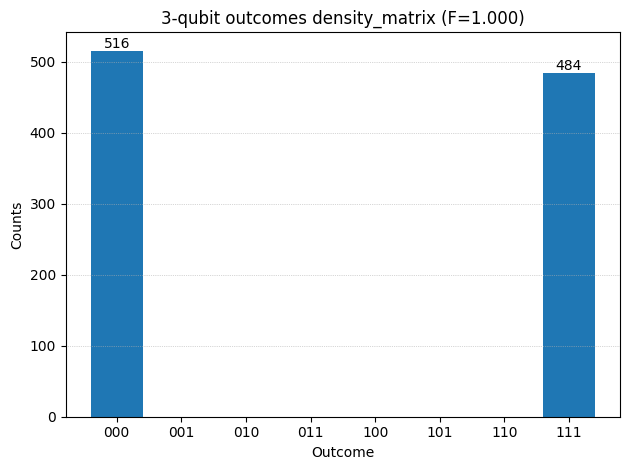




Testing Aer Simulator Method: stabilizer

Simulator Method: stabilizer
Available Qubits: 10000

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 10000,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 10000
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'000': 502, '111': 498}


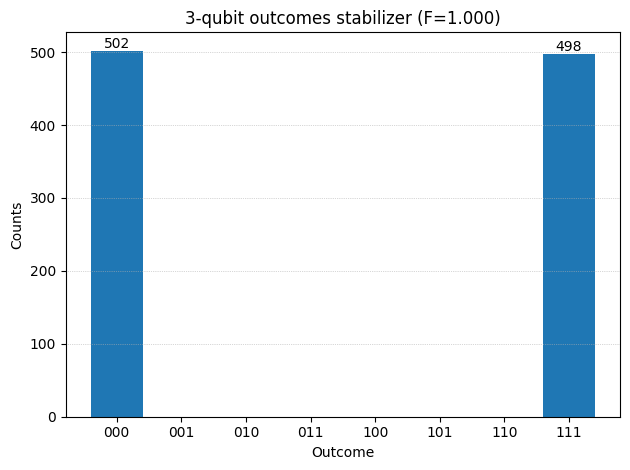




Testing Aer Simulator Method: matrix_product_state

Simulator Method: matrix_product_state
Available Qubits: 63

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 63,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 63
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'111': 478, '000': 522}


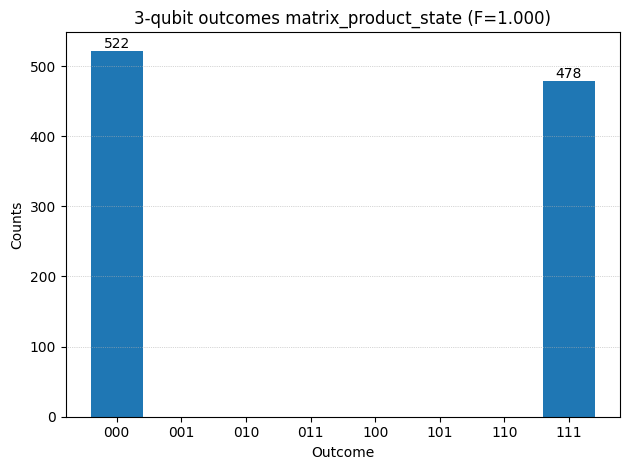




Testing Aer Simulator Method: extended_stabilizer

Simulator Method: extended_stabilizer
Available Qubits: 63

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 63,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 63
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'111': 488, '000': 512}


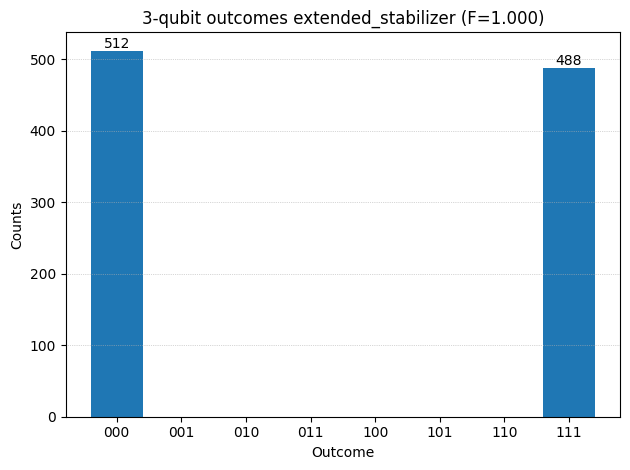




Testing Aer Simulator Method: unitary

Simulator Method: unitary
Available Qubits: 14

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 14,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 14
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'111': 514, '000': 486}


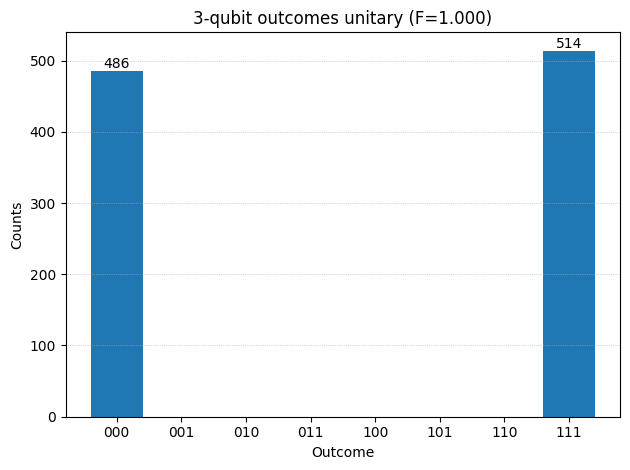




Testing Aer Simulator Method: superop

Simulator Method: superop
Available Qubits: 7

--- Checks PASSED ---

--- Calculated Properties ---
{
  "n_qubits": 7,
  "T1": {
    "mean": 0.0001,
    "median": 0.0001,
    "std": 0.0,
    "min": 0.0001,
    "max": 0.0001,
    "q25": 0.0001,
    "q75": 0.0001,
    "cv": 0.0,
    "comments": ""
  },
  "T2": {
    "mean": 8e-05,
    "median": 8e-05,
    "std": 0.0,
    "min": 8e-05,
    "max": 8e-05,
    "q25": 8e-05,
    "q75": 8e-05,
    "cv": 0.0,
    "comments": ""
  }
}

Number of Qubits: 7
-------------------------

--- Running Test Circuit in on_pass ---
Circuit executed successfully
Result counts: {'111': 470, '000': 530}


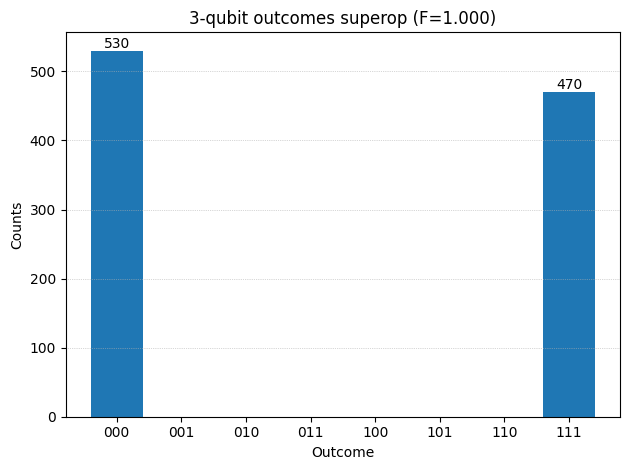




SUMMARY
automatic                 - Success
statevector               - Success
density_matrix            - Success
stabilizer                - Success
matrix_product_state      - Success
extended_stabilizer       - Success
unitary                   - Success
superop                   - Success


In [5]:
methods = [
    'automatic',
    'statevector',
    'density_matrix',
    'stabilizer',
    'matrix_product_state',
    'extended_stabilizer',
    'unitary',
    'superop'
]

print("\n" + "="*60)
print("TESTING ALL AER SIMULATOR METHODS")
print("="*60)

results = {}
for method in methods:
    result = test_aer_method(method, n_qubits=5, qubit_threshold=4)
    results[method] = result
    if result is not None and result.get('experiment_result') is not None:
        plot_results(result, method_name=method)
    else:
        print("No results to plot - make sure the test passed!")
    print("\n")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for method, result in results.items():
    status = "Success" if result is not None else "Failed"
    
    print(f"{method:25s} - {status}")